# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

# Download and import required packages

In [45]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [46]:
seed = 900405
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [47]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
# urls = (
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
# )
# file_names = (
#     'ted2020.tgz', # train & dev
#     'test.tgz', # test
# )
prefix = Path(data_dir).absolute() / dataset_name

# prefix.mkdir(parents=True, exist_ok=True)
# for u, f in zip(urls, file_names):
#     path = prefix/f
#     if not path.exists():
#         !wget {u} -O {path}
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
# !rm -rf {prefix/'test'}

## Language

In [48]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [49]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [50]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [51]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [52]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [53]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [54]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [55]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [56]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/home/csypt/桌面/ML/hw/hw5/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [57]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [58]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [59]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/transformer_bt",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [60]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [61]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-04-08 13:21:04 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-04-08 13:21:04 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 11.770 GB ; name = NVIDIA GeForce RTX 3060                 
2022-04-08 13:21:04 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [62]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-08 13:21:04 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2022-04-08 13:21:04 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [63]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-08 13:21:04 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-08 13:21:04 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.zh-en.zh
2022-04-08 13:21:04 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.zh-en.en
2022-04-08 13:21:04 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2022-04-08 13:21:04 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.zh-en.zh
2022-04-08 13:21:04 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.zh-en.en
2022-04-08 13:21:04 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [64]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([   5,  951, 2093, 2699, 1292,  177,    9,  763, 1105,   44, 2667, 1304,
          65,  416,  735,  362, 4436, 1046, 4052, 1948,  676,    2]),
 'target': tensor([ 667,  310, 1533,  141,   44, 1252,   42, 1616,    4,  344, 1143,  257,
         878,   37,   11,   17,    6,  491,  547,  316,   59,  885,    7,    2])}
'Source: 其中包括三個顯著的因素:領導能力、外交手腕以及憲政設計'
('Target: three things stand out: leadership , diplomacy and institutional '
 'design .')


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [65]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-08 13:21:04 | WARNING | fairseq.tasks.fairseq_task | 2,487 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[3683, 3508, 491, 1575, 588, 990, 3905, 1856, 865, 1153]


{'id': tensor([3903, 2860, 2353]),
 'nsentences': 3,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,   53,   30, 1586,   33,    2],
          [   1,    1,    1,    5, 2381, 2896,   10,    2],
          [   1,    1,    1,   53, 1643, 1020,  393,    2]]),
  'src_lengths': tensor([5, 5, 5]),
  'prev_output_tokens': tensor([[   2,   35,  172,   48,   22,   33,    1,    1],
          [   2,    8,  586, 2297,    6,    7,    1,    1],
          [   2,   22,   88,   56, 1140,    7,    1,    1]])},
 'target': tensor([[  35,  172,   48,   22,   33,    2,    1,    1],
         [   8,  586, 2297,    6,    7,    2,    1,    1],
         [  22,   88,   56, 1140,    7,    2,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [66]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [67]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [68]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [69]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    # encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [70]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=2048,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=2048,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [71]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [72]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-08 13:21:04 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=256, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [73]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [74]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    lr =  d_model** (-0.5) * min(step_num ** (-0.5), step_num * warmup_step ** (-1.5))
    return lr

In [75]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

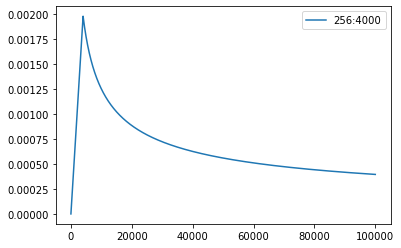

In [76]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [77]:
grad_norm = []

In [78]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        grad_norm.append(gnorm)

        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [79]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [80]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [81]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [82]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [83]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-08 13:21:05 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-08 13:21:05 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-08 13:21:05 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-08 13:21:05 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-08 13:21:05 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-08 13:21:05 | INFO | hw5.seq2seq | num. model params: 15,672,320 (num. trained: 15,672,320)
2022-04-08 13:21:05 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


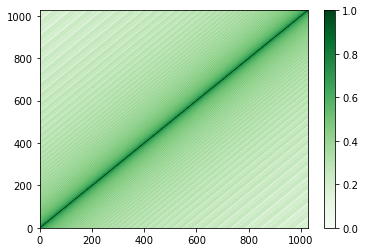

In [43]:
pos_emb = model.decoder.embed_positions.weights.cpu().detach()
cmap = plt.cm.get_cmap('Greens')
sim = []
for x in pos_emb:
    for y in pos_emb:
        sim.append(F.cosine_similarity(x, y, dim = 0))
plt.pcolor(np.array(sim).reshape(1026, 1026), cmap=cmap)
plt.colorbar()
plt.show()

In [84]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-08 13:21:08 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326663]
2022-04-08 13:21:08 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer_bt/checkpoint_last.pt!


2022-04-08 13:23:45 | INFO | hw5.seq2seq | training loss: 6.0354
2022-04-08 13:23:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/26 [00:00<?, ?it/s, valid_loss=3.78]/home/csypt/anaconda3/lib/python3.9/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/csypt/anaconda3/lib/python3.9/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundin

2022-04-08 13:24:01 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:24:01 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:24:01 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:24:01 | INFO | hw5.seq2seq | example source: 說實話 , 當我們談論對付窮人的暴力行為 , 用的方式有時候頗為怪異 。
2022-04-08 13:24:01 | INFO | hw5.seq2seq | example hypothesis: well , i'm going to do that we're going to be able to be a lot of resurces , and we're going to have a lot of resurpres .
2022-04-08 13:24:01 | INFO | hw5.seq2seq | example reference: and honestly , when we do talk about violence against the poor , sometimes it's in the weirdest of ways .
2022-04-08 13:24:01 | INFO | hw5.seq2seq | validation loss:	4.6798
2022-04-08 13:24:01 | INFO | hw5.seq2seq | BLEU = 1.27 21.8/2.6/0.4/0.1 (BP = 1.000 ratio = 1.052 hyp_l

2022-04-08 13:26:37 | INFO | hw5.seq2seq | training loss: 4.2722
2022-04-08 13:26:37 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:26:51 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:26:51 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:26:51 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:26:51 | INFO | hw5.seq2seq | example source: 就像擲硬幣作決定一樣毫無意義可言
2022-04-08 13:26:51 | INFO | hw5.seq2seq | example hypothesis: it's like the hardware , and it's like a serious construction .
2022-04-08 13:26:51 | INFO | hw5.seq2seq | example reference: it's like a coin flip ; it doesn't count , really .
2022-04-08 13:26:51 | INFO | hw5.seq2seq | validation loss:	3.7581
2022-04-08 13:26:51 | INFO | hw5.seq2seq | BLEU = 6.99 38.5/11.8/4.5/1.9 (BP = 0.889 ratio = 0.895 hyp_len = 68021 ref_len = 75991)
2022-04-08 13:26:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints

2022-04-08 13:29:25 | INFO | hw5.seq2seq | training loss: 3.6342
2022-04-08 13:29:25 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:29:38 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:29:38 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:29:38 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:29:38 | INFO | hw5.seq2seq | example source: 因為最終我們所做的事都是發生在這個框框裡面在有限的資源下
2022-04-08 13:29:38 | INFO | hw5.seq2seq | example hypothesis: because ultimately , what's happening in this framework .
2022-04-08 13:29:38 | INFO | hw5.seq2seq | example reference: because ultimately , most of what we do takes place here , inside the box , with limited resources .
2022-04-08 13:29:38 | INFO | hw5.seq2seq | validation loss:	3.3375
2022-04-08 13:29:38 | INFO | hw5.seq2seq | BLEU = 10.60 48.8/18.8/8.6/4.1 (BP = 0.791 ratio = 0.810 hyp_len = 61575 ref_len = 75991)
2022-04-08 13:29:38 | INFO | hw5.seq2seq | save

2022-04-08 13:32:12 | INFO | hw5.seq2seq | training loss: 3.3327
2022-04-08 13:32:12 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:32:26 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:32:26 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:32:26 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:32:26 | INFO | hw5.seq2seq | example source: 忽然之間 , 我開竅了
2022-04-08 13:32:26 | INFO | hw5.seq2seq | example hypothesis: i'm going to go and i'm going to do it .
2022-04-08 13:32:26 | INFO | hw5.seq2seq | example reference: and then it hit me .
2022-04-08 13:32:26 | INFO | hw5.seq2seq | validation loss:	3.1534
2022-04-08 13:32:26 | INFO | hw5.seq2seq | BLEU = 12.23 49.4/20.0/9.5/4.6 (BP = 0.849 ratio = 0.859 hyp_len = 65280 ref_len = 75991)
2022-04-08 13:32:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint4.pt
2022-04-08 13:32:26 | INFO 

2022-04-08 13:35:00 | INFO | hw5.seq2seq | training loss: 3.1766
2022-04-08 13:35:00 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:35:15 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:35:15 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:35:15 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:35:15 | INFO | hw5.seq2seq | example source: 你可以說是 , 也可以說不是 ; 但這個問題的答案不是這麼表面的 。
2022-04-08 13:35:15 | INFO | hw5.seq2seq | example hypothesis: you can say it's not ; it's not the answer , but the answer is not the surface of the problem .
2022-04-08 13:35:15 | INFO | hw5.seq2seq | example reference: and the answer is yes and no ; it's deeper than all of that .
2022-04-08 13:35:15 | INFO | hw5.seq2seq | validation loss:	3.0596
2022-04-08 13:35:15 | INFO | hw5.seq2seq | BLEU = 13.89 48.3/20.2/9.8/4.9 (BP = 0.942 ratio = 0.944 hyp_len = 71701 ref_len = 75991)
2022-04-08 13:35:15 | INFO | hw5.seq2seq |

train epoch 6:  85%|████████▍ | 678/800 [02:10<00:23,  5.14it/s, loss=3.05]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf933dfca0>
Traceback (most recent call last):
  File "/home/csypt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/csypt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/csypt/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
train epoch 6:  91%|█████████▏| 730/800 [02:20<00:13,  5.03it/s, loss=2.78]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf933dfca0>
Traceback (most recent call last):
  File "/home/csypt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1

2022-04-08 13:37:49 | INFO | hw5.seq2seq | training loss: 3.0596
2022-04-08 13:37:49 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:38:03 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:38:03 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:38:03 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:38:03 | INFO | hw5.seq2seq | example source: 但我在我的智慧家庭中的經歷並非如此 。
2022-04-08 13:38:03 | INFO | hw5.seq2seq | example hypothesis: but it's not my experience in my smart family .
2022-04-08 13:38:03 | INFO | hw5.seq2seq | example reference: but that wasn't my experience in my smart home .
2022-04-08 13:38:03 | INFO | hw5.seq2seq | validation loss:	2.9356
2022-04-08 13:38:03 | INFO | hw5.seq2seq | BLEU = 14.68 53.1/23.2/11.7/6.2 (BP = 0.848 ratio = 0.858 hyp_len = 65217 ref_len = 75991)
2022-04-08 13:38:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_b

train epoch 7:   0%|          | 0/800 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf933dfca0>
Traceback (most recent call last):
  File "/home/csypt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/csypt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/csypt/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcf933dfca0>
Traceback (most recent call last):
  File "/home/csypt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/csypt/anaconda3/lib/python3.9/site-pa

2022-04-08 13:40:37 | INFO | hw5.seq2seq | training loss: 2.9538
2022-04-08 13:40:37 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:40:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:40:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:40:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:40:50 | INFO | hw5.seq2seq | example source: 我認為我們可以進入一個新時代我稱之為 「 零期醫學 」 的時代 。 作為一名癌症醫生 , 我期待失業 。
2022-04-08 13:40:50 | INFO | hw5.seq2seq | example hypothesis: i think we can go into a new era where i call zero medicine .
2022-04-08 13:40:50 | INFO | hw5.seq2seq | example reference: we have adult stem cells throughout our body ; we use those in bone marrow transplantation .
2022-04-08 13:40:50 | INFO | hw5.seq2seq | validation loss:	2.8781
2022-04-08 13:40:50 | INFO | hw5.seq2seq | BLEU = 14.59 56.0/25.3/13.2/7.1 (BP = 0.765 ratio = 0.789 hyp_len = 59935 ref_len = 75991)
2022-04-08 13:40:50 | INFO

2022-04-08 13:43:24 | INFO | hw5.seq2seq | training loss: 2.8751
2022-04-08 13:43:24 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:43:38 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:43:38 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:43:38 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:43:38 | INFO | hw5.seq2seq | example source: 今天會場不能在你們面前設置全身鏡 , 但我要你想一句自己會對鏡中的自己說的話 。 用自我肯定的語言 。
2022-04-08 13:43:38 | INFO | hw5.seq2seq | example hypothesis: today , you can't put all the lenses in front of you , but i want you to think of yourself in the mirror .
2022-04-08 13:43:38 | INFO | hw5.seq2seq | example reference: there may not be a fulllength mirror in front of each of you today , but i want to challenge you to think about what you would want to say to yourself in the mirror with your own selfaffirming words .
2022-04-08 13:43:38 | INFO | hw5.seq2seq | validation loss:	2.8289
2022-04-

2022-04-08 13:46:12 | INFO | hw5.seq2seq | training loss: 2.8175
2022-04-08 13:46:12 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:46:25 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:46:25 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:46:25 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:46:25 | INFO | hw5.seq2seq | example source: 所以如果我們能利用科技來幫助解決教育問題 , 幫助解決環境問題 , 幫助解決大規模傳染問題 , 這不就能解決當年我在wired雜誌上所提到那些大問題了嗎 ? 恐怕不會 , 因為你不能光只靠科技來解決一個問題 。
2022-04-08 13:46:25 | INFO | hw5.seq2seq | example hypothesis: so if we can use technology to help educational issues , help the environmental problems , help solve largescale infectious problems , it won't be the case that i mentioned in wired magazine ?
2022-04-08 13:46:25 | INFO | hw5.seq2seq | example reference: so if we can address , use technology , help address education , help address the environment , help address the pandemic , does that so

2022-04-08 13:48:59 | INFO | hw5.seq2seq | training loss: 2.7702
2022-04-08 13:48:59 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:49:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:49:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:49:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:49:12 | INFO | hw5.seq2seq | example source: 「 我想結婚的時候才結婚 。
2022-04-08 13:49:12 | INFO | hw5.seq2seq | example hypothesis: " i want to get married .
2022-04-08 13:49:12 | INFO | hw5.seq2seq | example reference: " i'll marry when i want .
2022-04-08 13:49:12 | INFO | hw5.seq2seq | validation loss:	2.7692
2022-04-08 13:49:12 | INFO | hw5.seq2seq | BLEU = 16.96 56.0/26.4/14.2/7.9 (BP = 0.842 ratio = 0.853 hyp_len = 64856 ref_len = 75991)
2022-04-08 13:49:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint10.pt
2022-04-08 13:49:12 | INFO | hw

2022-04-08 13:51:46 | INFO | hw5.seq2seq | training loss: 2.7350
2022-04-08 13:51:46 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:52:00 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:52:00 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:52:00 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:52:00 | INFO | hw5.seq2seq | example source: 更糟的是
2022-04-08 13:52:00 | INFO | hw5.seq2seq | example hypothesis: it's even worse .
2022-04-08 13:52:00 | INFO | hw5.seq2seq | example reference: but it gets worse .
2022-04-08 13:52:00 | INFO | hw5.seq2seq | validation loss:	2.7393
2022-04-08 13:52:00 | INFO | hw5.seq2seq | BLEU = 17.59 55.7/26.4/14.4/8.1 (BP = 0.864 ratio = 0.872 hyp_len = 66294 ref_len = 75991)
2022-04-08 13:52:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint11.pt
2022-04-08 13:52:00 | INFO | hw5.seq2seq | end of epoch 

2022-04-08 13:54:34 | INFO | hw5.seq2seq | training loss: 2.7040
2022-04-08 13:54:34 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:54:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:54:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:54:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:54:47 | INFO | hw5.seq2seq | example source: 但是-訣竅在這fehr和gachter在第七輪的時候和每個人說 " 好的,新規則
2022-04-08 13:54:47 | INFO | hw5.seq2seq | example hypothesis: but the trick is this fehr and gchter , and when it comes to the seventh round , it says , " good , new rules .
2022-04-08 13:54:47 | INFO | hw5.seq2seq | example reference: but then and here's the trick fehr and gächter , on the seventh round , told people , " you know what ? new rule .
2022-04-08 13:54:47 | INFO | hw5.seq2seq | validation loss:	2.7167
2022-04-08 13:54:47 | INFO | hw5.seq2seq | BLEU = 18.35 54.1/25.6/13.8/7.8 (BP = 0.933 ratio = 0.936

2022-04-08 13:57:21 | INFO | hw5.seq2seq | training loss: 2.6777
2022-04-08 13:57:21 | INFO | hw5.seq2seq | begin validation


2022-04-08 13:57:35 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 13:57:35 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 13:57:35 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 13:57:35 | INFO | hw5.seq2seq | example source: 我們可以不要讓郵遞區號成為決定你壽命長短的主要因素 。
2022-04-08 13:57:35 | INFO | hw5.seq2seq | example hypothesis: we can not let the post zone become the principal factor of deciding your lifespan .
2022-04-08 13:57:35 | INFO | hw5.seq2seq | example reference: we can stop making your zip code the primary determinant of your lifespan .
2022-04-08 13:57:35 | INFO | hw5.seq2seq | validation loss:	2.7111
2022-04-08 13:57:35 | INFO | hw5.seq2seq | BLEU = 18.74 54.1/25.8/14.0/7.8 (BP = 0.949 ratio = 0.950 hyp_len = 72181 ref_len = 75991)
2022-04-08 13:57:35 | INFO | hw5.seq2seq | sa

2022-04-08 14:00:09 | INFO | hw5.seq2seq | training loss: 2.6554
2022-04-08 14:00:09 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:00:22 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:00:22 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:00:22 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:00:22 | INFO | hw5.seq2seq | example source: 他們的文化已經遭到了破壞 , 他們賴以生存的動物也面臨滅絕 。
2022-04-08 14:00:22 | INFO | hw5.seq2seq | example hypothesis: their culture has been destroyed , and they're facing extinction with survival animals .
2022-04-08 14:00:22 | INFO | hw5.seq2seq | example reference: their culture is being destroyed , along with the animals upon whom they depend .
2022-04-08 14:00:22 | INFO | hw5.seq2seq | validation loss:	2.6943
2022-04-08 14:00:22 | INFO | hw5.seq2seq | BLEU = 18.67 56.5/27.3/15.1/8.5 (BP = 0.885 ratio = 0.891 hyp_len = 67722 ref_len = 75991)
2022-04-08 14:00:22 | INFO | hw

2022-04-08 14:02:56 | INFO | hw5.seq2seq | training loss: 2.6352
2022-04-08 14:02:56 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:03:10 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:03:10 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:03:10 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:03:10 | INFO | hw5.seq2seq | example source: 看看女性發生什麼變化 ? 男性又發生什麼變化 ?
2022-04-08 14:03:10 | INFO | hw5.seq2seq | example hypothesis: what happens ? what happens to men ?
2022-04-08 14:03:10 | INFO | hw5.seq2seq | example reference: watch what happens to the women . watch what happens to the men .
2022-04-08 14:03:10 | INFO | hw5.seq2seq | validation loss:	2.6967
2022-04-08 14:03:10 | INFO | hw5.seq2seq | BLEU = 18.47 56.4/27.2/14.9/8.4 (BP = 0.882 ratio = 0.888 hyp_len = 67500 ref_len = 75991)
2022-04-08 14:03:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/tr

2022-04-08 14:05:44 | INFO | hw5.seq2seq | training loss: 2.6179
2022-04-08 14:05:44 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:05:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:05:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:05:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:05:58 | INFO | hw5.seq2seq | example source: 這些可以幫助我們設計出更會爬牆的機器人嗎 ?
2022-04-08 14:05:58 | INFO | hw5.seq2seq | example hypothesis: can we design robots that climb walls ?
2022-04-08 14:05:58 | INFO | hw5.seq2seq | example reference: now will this help us think about the design of more effective climbing robots ?
2022-04-08 14:05:58 | INFO | hw5.seq2seq | validation loss:	2.6746
2022-04-08 14:05:58 | INFO | hw5.seq2seq | BLEU = 18.89 57.3/28.0/15.5/8.9 (BP = 0.869 ratio = 0.877 hyp_len = 66667 ref_len = 75991)
2022-04-08 14:05:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw

2022-04-08 14:08:33 | INFO | hw5.seq2seq | training loss: 2.6000
2022-04-08 14:08:33 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:08:47 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:08:47 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:08:47 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:08:47 | INFO | hw5.seq2seq | example source: 那只是個科學問題
2022-04-08 14:08:47 | INFO | hw5.seq2seq | example hypothesis: that's just a scientific question .
2022-04-08 14:08:47 | INFO | hw5.seq2seq | example reference: it's a scientific question , after all .
2022-04-08 14:08:47 | INFO | hw5.seq2seq | validation loss:	2.6713
2022-04-08 14:08:47 | INFO | hw5.seq2seq | BLEU = 19.25 56.5/27.5/15.2/8.8 (BP = 0.902 ratio = 0.906 hyp_len = 68883 ref_len = 75991)
2022-04-08 14:08:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint17.pt
2022-04-08 14

2022-04-08 14:11:21 | INFO | hw5.seq2seq | training loss: 2.5872
2022-04-08 14:11:21 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:11:35 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:11:35 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:11:35 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:11:35 | INFO | hw5.seq2seq | example source: 求算還是快些 , 也實際些
2022-04-08 14:11:35 | INFO | hw5.seq2seq | example hypothesis: calculations are faster and more practical .
2022-04-08 14:11:35 | INFO | hw5.seq2seq | example reference: it's still quicker to do that and more practical .
2022-04-08 14:11:35 | INFO | hw5.seq2seq | validation loss:	2.6668
2022-04-08 14:11:35 | INFO | hw5.seq2seq | BLEU = 19.07 57.0/27.7/15.4/8.8 (BP = 0.887 ratio = 0.893 hyp_len = 67834 ref_len = 75991)
2022-04-08 14:11:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/check

2022-04-08 14:14:09 | INFO | hw5.seq2seq | training loss: 2.5749
2022-04-08 14:14:09 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:14:23 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:14:23 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:14:23 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:14:23 | INFO | hw5.seq2seq | example source: 我一聽到該錄音 , 我就知道這將會是那種心有所感的片段 , 能夠實切地描繪出當下食物銀行正發生的事情 。
2022-04-08 14:14:23 | INFO | hw5.seq2seq | example hypothesis: and as soon as i heard the recording , i understood that this was going to be a snippet of feeling that i could actually describe what's happening in the current food bank .
2022-04-08 14:14:23 | INFO | hw5.seq2seq | example reference: as soon as i heard that audio , i knew that this would be the kind of evocative piece that could really describe what was going on at food banks .
2022-04-08 14:14:23 | INFO | hw5.seq2seq | validation loss:	2

2022-04-08 14:16:57 | INFO | hw5.seq2seq | training loss: 2.5618
2022-04-08 14:16:57 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:17:10 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:17:10 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:17:10 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:17:10 | INFO | hw5.seq2seq | example source: 它是個人口超過十億的國家 。
2022-04-08 14:17:10 | INFO | hw5.seq2seq | example hypothesis: it's a country of over a billion .
2022-04-08 14:17:10 | INFO | hw5.seq2seq | example reference: it's a country of over a billion people .
2022-04-08 14:17:10 | INFO | hw5.seq2seq | validation loss:	2.6552
2022-04-08 14:17:10 | INFO | hw5.seq2seq | BLEU = 19.34 55.7/27.0/14.9/8.5 (BP = 0.925 ratio = 0.927 hyp_len = 70464 ref_len = 75991)
2022-04-08 14:17:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint20.pt
2022-04

2022-04-08 14:19:44 | INFO | hw5.seq2seq | training loss: 2.5500
2022-04-08 14:19:44 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:19:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:19:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:19:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:19:58 | INFO | hw5.seq2seq | example source: 你最近下載了什麼手機軟體 ?
2022-04-08 14:19:58 | INFO | hw5.seq2seq | example hypothesis: what software did you download recently ?
2022-04-08 14:19:58 | INFO | hw5.seq2seq | example reference: what's the last app you downloaded ?
2022-04-08 14:19:58 | INFO | hw5.seq2seq | validation loss:	2.6537
2022-04-08 14:19:58 | INFO | hw5.seq2seq | BLEU = 19.44 56.5/27.7/15.3/8.7 (BP = 0.909 ratio = 0.913 hyp_len = 69385 ref_len = 75991)
2022-04-08 14:19:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint21.pt
2022-

2022-04-08 14:22:31 | INFO | hw5.seq2seq | training loss: 2.5403
2022-04-08 14:22:31 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:22:45 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:22:45 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:22:45 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:22:45 | INFO | hw5.seq2seq | example source: 所以要是你認為我錯了 , 你最好好好找出為什麼你認為我是錯的 。
2022-04-08 14:22:45 | INFO | hw5.seq2seq | example hypothesis: so if you think i'm wrong , you'd better find out why you think i'm wrong .
2022-04-08 14:22:45 | INFO | hw5.seq2seq | example reference: so if you think that i'm wrong , you'd better damn well go and find out why you think i'm wrong .
2022-04-08 14:22:45 | INFO | hw5.seq2seq | validation loss:	2.6461
2022-04-08 14:22:45 | INFO | hw5.seq2seq | BLEU = 19.63 56.6/27.8/15.4/8.8 (BP = 0.914 ratio = 0.918 hyp_len = 69730 ref_len = 75991)
2022-04-08 14:22:45 | INFO 

2022-04-08 14:25:18 | INFO | hw5.seq2seq | training loss: 2.5296
2022-04-08 14:25:18 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:25:31 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:25:31 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:25:31 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:25:31 | INFO | hw5.seq2seq | example source: 這不糟 , 因為你去了紐約州立大學石溪分校數學生涯更上層樓
2022-04-08 14:25:31 | INFO | hw5.seq2seq | example hypothesis: that's not bad , because you went to new york state stream , and the students went upstairs .
2022-04-08 14:25:31 | INFO | hw5.seq2seq | example reference: ca: it wasn't bad , because you went on to stony brook and stepped up your mathematical career .
2022-04-08 14:25:31 | INFO | hw5.seq2seq | validation loss:	2.6499
2022-04-08 14:25:31 | INFO | hw5.seq2seq | BLEU = 19.26 57.9/28.6/16.1/9.3 (BP = 0.864 ratio = 0.872 hyp_len = 66300 ref_len = 75991)
2022-04-08 14

2022-04-08 14:28:04 | INFO | hw5.seq2seq | training loss: 2.5215
2022-04-08 14:28:04 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:28:18 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:28:18 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:28:18 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:28:18 | INFO | hw5.seq2seq | example source: 這位是kathleenmaxian ,
2022-04-08 14:28:18 | INFO | hw5.seq2seq | example hypothesis: this is kathleen maxian .
2022-04-08 14:28:18 | INFO | hw5.seq2seq | example reference: this is kathleen maxian .
2022-04-08 14:28:18 | INFO | hw5.seq2seq | validation loss:	2.6370
2022-04-08 14:28:18 | INFO | hw5.seq2seq | BLEU = 19.62 56.8/28.0/15.7/9.0 (BP = 0.902 ratio = 0.907 hyp_len = 68905 ref_len = 75991)
2022-04-08 14:28:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint24.pt
2022-04-08 14:28:18 | INFO 

2022-04-08 14:30:51 | INFO | hw5.seq2seq | training loss: 2.5135
2022-04-08 14:30:51 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:31:04 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:31:04 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:31:04 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:31:04 | INFO | hw5.seq2seq | example source: 聯合國憲章 , 及一般說的布雷頓森林協定 , 世界銀行 , 國際貨幣基金 。
2022-04-08 14:31:04 | INFO | hw5.seq2seq | example hypothesis: the u . n . constitution , the breton forest , the world bank , the international currency fund .
2022-04-08 14:31:04 | INFO | hw5.seq2seq | example reference: the charter of the united nations , the bretton woods institutions , as they're called , the world bank , and the international monetary fund .
2022-04-08 14:31:04 | INFO | hw5.seq2seq | validation loss:	2.6424
2022-04-08 14:31:04 | INFO | hw5.seq2seq | BLEU = 19.67 57.0/28.1/15.7/9.1 (BP = 0.898 

2022-04-08 14:33:38 | INFO | hw5.seq2seq | training loss: 2.5064
2022-04-08 14:33:38 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:33:51 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:33:51 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:33:51 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:33:51 | INFO | hw5.seq2seq | example source: 大約一年之後我被允許做這個編外的項目 。
2022-04-08 14:33:51 | INFO | hw5.seq2seq | example hypothesis: about a year later , i was allowed to do this program .
2022-04-08 14:33:51 | INFO | hw5.seq2seq | example reference: i got permission in the end after about a year to basically do it as a side project .
2022-04-08 14:33:51 | INFO | hw5.seq2seq | validation loss:	2.6412
2022-04-08 14:33:51 | INFO | hw5.seq2seq | BLEU = 19.74 57.7/28.7/16.2/9.5 (BP = 0.878 ratio = 0.885 hyp_len = 67224 ref_len = 75991)
2022-04-08 14:33:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /hom

2022-04-08 14:36:25 | INFO | hw5.seq2seq | training loss: 2.4985
2022-04-08 14:36:25 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:36:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:36:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:36:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:36:39 | INFO | hw5.seq2seq | example source: 人們戰慄、逃跑因為我們使用恐懼
2022-04-08 14:36:39 | INFO | hw5.seq2seq | example hypothesis: people are sharing , because we're using fear .
2022-04-08 14:36:39 | INFO | hw5.seq2seq | example reference: people are freezing and running away because we're using fear .
2022-04-08 14:36:39 | INFO | hw5.seq2seq | validation loss:	2.6329
2022-04-08 14:36:39 | INFO | hw5.seq2seq | BLEU = 19.83 56.1/27.5/15.3/8.9 (BP = 0.926 ratio = 0.929 hyp_len = 70594 ref_len = 75991)
2022-04-08 14:36:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/tr

2022-04-08 14:39:13 | INFO | hw5.seq2seq | training loss: 2.4924
2022-04-08 14:39:13 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:39:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:39:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:39:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:39:27 | INFO | hw5.seq2seq | example source: 這塊地等著再次被水覆蓋、被吞噬 。
2022-04-08 14:39:27 | INFO | hw5.seq2seq | example hypothesis: this land is waiting to be covered with water again , swallowed .
2022-04-08 14:39:27 | INFO | hw5.seq2seq | example reference: the terrain was waiting to be covered over by the water , to be consumed .
2022-04-08 14:39:27 | INFO | hw5.seq2seq | validation loss:	2.6329
2022-04-08 14:39:27 | INFO | hw5.seq2seq | BLEU = 19.74 56.6/27.8/15.5/9.0 (BP = 0.911 ratio = 0.915 hyp_len = 69513 ref_len = 75991)
2022-04-08 14:39:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/cs

2022-04-08 14:42:01 | INFO | hw5.seq2seq | training loss: 2.4852
2022-04-08 14:42:01 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:42:15 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:42:15 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:42:15 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:42:15 | INFO | hw5.seq2seq | example source: 幾分鐘後氫氣與氦氣充滿了宇宙
2022-04-08 14:42:15 | INFO | hw5.seq2seq | example hypothesis: a few minutes later , hydrogen and helium filled with the universe .
2022-04-08 14:42:15 | INFO | hw5.seq2seq | example reference: after about a few minutes , there was hydrogen and helium in the universe . that's all .
2022-04-08 14:42:15 | INFO | hw5.seq2seq | validation loss:	2.6364
2022-04-08 14:42:15 | INFO | hw5.seq2seq | BLEU = 19.68 57.0/28.1/15.8/9.2 (BP = 0.896 ratio = 0.901 hyp_len = 68501 ref_len = 75991)
2022-04-08 14:42:15 | INFO | hw5.seq2seq | saved epoch checkp

2022-04-08 14:44:49 | INFO | hw5.seq2seq | training loss: 2.4782
2022-04-08 14:44:49 | INFO | hw5.seq2seq | begin validation


2022-04-08 14:45:03 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-08 14:45:03 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-08 14:45:03 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-08 14:45:03 | INFO | hw5.seq2seq | example source: 我們的策略並非大體制的改變 ,
2022-04-08 14:45:03 | INFO | hw5.seq2seq | example hypothesis: our strategies are not changing the system .
2022-04-08 14:45:03 | INFO | hw5.seq2seq | example reference: our strategy is not massive system change .
2022-04-08 14:45:03 | INFO | hw5.seq2seq | validation loss:	2.6284
2022-04-08 14:45:03 | INFO | hw5.seq2seq | BLEU = 19.91 56.2/27.7/15.4/8.9 (BP = 0.926 ratio = 0.929 hyp_len = 70568 ref_len = 75991)
2022-04-08 14:45:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/csypt/桌面/ML/hw/hw5/checkpoints/transformer_bt/checkpoint

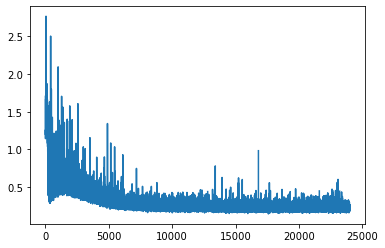

In [86]:
data = [x.item() for x in grad_norm]
plt.plot(data)
plt.show()

# Submission

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

## Confirm model weights used to generate submission

In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None